*** 
This code example is a Jupyter notebook with [Script of Scripts](https://vatlab.github.io/sos-docs/) (SoS) workflow. It reproduces interactive figures for the paper by first author **Ardi Tampuu** and last author **Raul Vicente**. 


The calculations are written using *Python 2.7* (from this fetched from [repo](https://github.com/NeuroCSUT/RatGPS)), and the interactive figures are written in *Python 3.6* with the ploting library [Plotly](https://plotly.com/).  

# Figure 4:

**(a)** The trajectory of the rat during the entire trial. Not all parts of the arena are visited with equal frequently. **(b)** The average size of errors made in different regions of space. Color of each hexagon depicts the average euclidean error of data points falling into the hexagon. More frequently visited areas (as seen from **(a)**) tend to have lower mean error. **(c)** Sum neural activity in different regions of space. For each data point we sum the spike counts of all 63 neurons in a 1400 ms period centered around the moment the location was recorded. The color of the hexagon corresponds to the average over all data points falling into the hexagon. Areas where sum neural activity is high have lower prediction error. **(d)** Prediction error of a coordinate decreases if the animal is closer to the wall perpendicular to that coordinate.

https://doi.org/10.1371/journal.pcbi.1006822.g004

## Python 2.7
***
Figure 4.a: **Trajectory of R2192**, Matplotlib 

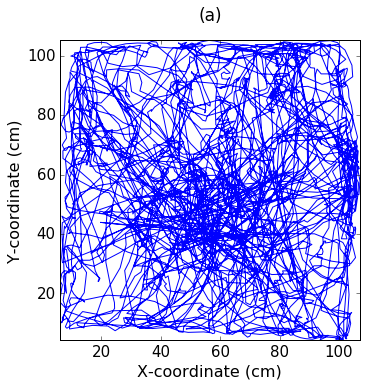

In [26]:
%use Python2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import math
import scipy.io as scio
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
%matplotlib inline

data = np.load("R2192_models/window_scan_R2192_1x1400_predictions_v1.npz")
y = data["targets"]

plt.figure(figsize=(5.2,5))
plt.plot(y[:,0], y[:,1]);
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.title("(a)", fontsize=17,y=1.05,x=0.5)
plt.show()

Figure 4.b: **Mean prediction error for diffrent regions for R2192**, Matplotlib

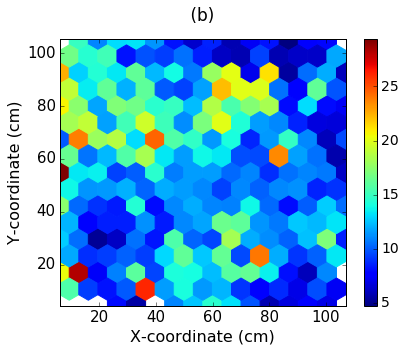

In [23]:
%use Python2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from scipy.stats import binned_statistic
import math

import scipy.io as scio

import matplotlib.style
# import matplotlib as mpl
# mpl.style.use('classic')


# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
def mse(y, t, axis=2):
    return (np.square(y - t).mean(axis=axis).mean())

def mean_distance(y, t, axis=2):
    return np.mean(np.sqrt(np.sum((y - t)**2, axis=axis)))

def median_distance(y, t, axis=2):
    return np.median(np.sqrt(np.sum((y - t)**2, axis=axis)))

cvfolds = 10
data = np.load("R2192_models/window_scan_R2192_1x1400_predictions_v1.npz")

# print type(data), data.keys()

pred_y = data["preds"]
y = data["targets"]
targets = data["targets"]

# print pred_y.shape, targets.shape

seqlen = pred_y.shape[1]
pred_y = pred_y.reshape((-1, 2))

errors = np.sqrt(np.sum((pred_y - y)**2, axis=1))

# WHAT IS CHANCE LEVEL ACCURACY?
r_y = y.copy()
np.random.shuffle(r_y)


all_preds = []
all_errors =[]

# assumes there are predictions from 10 CV-runs in the folder R2192_models
for i in range(1,11):
    data = np.load("R2192_models/window_scan_R2192_1x1400_predictions_v"+str(i)+".npz")
    pr_i = data["preds"]
    tgts = data["targets"]
    assert np.all(tgts==targets) #should always be same
    
    all_preds.append(pr_i)
    errors_i = np.sqrt(np.sum((pr_i - y)**2, axis=1))
    all_errors.append(errors_i) # we record errors of each model individually, not the error made by ensemble model	

    
# print "we have in total error size: ", np.shape(all_preds), np.shape(all_errors), np.mean(np.ravel(all_errors))
avg_pred = np.mean(all_preds,axis=0) # this gives us the prediction of ensemble model
avg_errors = np.mean(all_errors,axis=0) #this gives us the average of errors for each location, not error of ensemble model!
median_errors = np.median(all_errors,axis=0)


plt.figure(figsize=(6,5))
plt.title(" (b) ", fontsize=17,y=1.05,x=0.5)
plt.hexbin(y[:,0], y[:,1],C=avg_errors, gridsize=15)
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar( ticks=[5,10,15,20,25])
cbar.ax.set_yticklabels([5,10,15,20,25],fontsize=14)
#cbar.ax.set_yticklabels(["5 cm","10 cm","15 cm","20 cm","25 cm"],fontsize=14)
#cbar.ax.set_title('Mean error',fontsize=14)
plt.tight_layout()
plt.show()

Figure 4.c: **Sum neural activity in spikes/s in different regions for R2192**,  Matplotlib

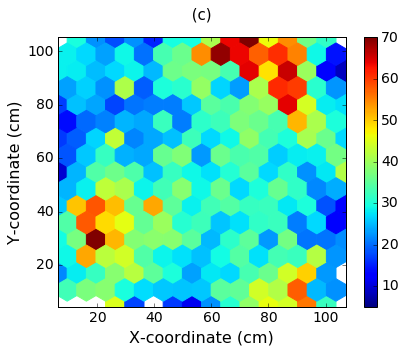

In [36]:
%use Python2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import binned_statistic
import math
import scipy.io as scio
import matplotlib.style
# import matplotlib as mpl
# mpl.style.use('classic')
from sklearn.model_selection import KFold

def min_dist_in_train(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.min(dist_2)

def nearby_in_train(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    ordered = sorted(dist_2)
    ii=0
    while ordered[ii]<10:
        ii+=1
    return ii

raw_y = np.loadtxt("data/R2192_1x1400_at35_step200_bin100-RAW_pos.dat")
raw_feat = np.loadtxt("data/R2192_1x1400_at35_step200_bin100-RAW_feat.dat")

closest_points=[]
count_nearby = []
activity=[]

kf = KFold(n_splits=10)


for i, (rest_idx, test_idx) in enumerate(kf.split(raw_y)):
    if np.min(test_idx)==0: #first fol left out
        rest_idx = np.array(sorted(rest_idx)[99:])
        test_idx = np.array(sorted(test_idx)[99:])
    elif np.max(test_idx)== raw_y.shape[0]-1: #last fold left out
        rest_idx = np.array(sorted(rest_idx)[99:])
        test_idx = np.array(sorted(test_idx)[99:])
    else:
        assert (np.min(test_idx)>np.min(rest_idx))
        assert (np.max(test_idx)<np.max(rest_idx))
        
        all_idx = np.array(range(raw_y.shape[0]))
        #print all_idx[99:np.min(test_idx)].shape,all_idx[np.max(test_idx)+100:].shape
        rest_idx = np.hstack((all_idx[99:np.min(test_idx)],all_idx[np.max(test_idx)+100:]))
        test_idx = np.array(sorted(test_idx)[99:])
#     print "Fold nr ",i," shapes ", test_idx.shape, rest_idx.shape     
    test = raw_y[test_idx]
    rest = raw_y[rest_idx]
    for loc in test:
        closest_points.append(min_dist_in_train(loc,rest))
        count_nearby.append(nearby_in_train(loc,rest))
    # find the lines in activity matrix, sum and append
    test_activity = np.sum(raw_feat[test_idx,:],axis=1)
    activity = np.concatenate([activity,test_activity])


# This is based on only train set and on 1400ms windows
plt.figure(figsize=(6,5))
plt.title(" (c) ",fontsize=15, y=1.05, x=0.5)
plt.hexbin(y[:,0], y[:,1],C=activity/1.4, gridsize=15, vmin=5, vmax=70)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar(ticks=[0,10,20,30,40,50,60,70]);
cbar.ax.set_yticklabels([10,20,30,40,50,60,70],fontsize=14)
plt.tight_layout()
plt.show()

Figure 4.d: <b>$Error_y = f(D_{horizontal\_wall})$</b>, Matplotlib

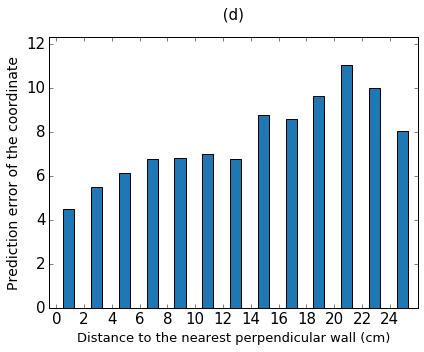

In [37]:
%use Python2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import binned_statistic
import math
import scipy.io as scio
import matplotlib.style
# import matplotlib as mpl
# mpl.style.use('classic')

xerrors = np.abs(avg_pred[:,0] - y[:,0])
yerrors = np.abs(avg_pred[:,1] - y[:,1])
bins = np.arange(0,100.1, 2)

plt.figure(figsize=(6,5))

all_1D_err = np.concatenate((xerrors,yerrors))
all_distances_to_wall = np.concatenate((50-np.abs(y[:,0]-50),50-np.abs(y[:,1]-50)))
statistic, bin_edges, binnumber = binned_statistic(all_distances_to_wall, all_1D_err, statistic='mean', bins=bins)
plt.bar(bin_edges[1:]-1.5, statistic, color=tableau20[0])
plt.title(" (d) ",fontsize=15, y=1.05, x=0.5)
plt.ylabel("Prediction error of the coordinate",fontsize=14)
plt.xlabel("Distance to the nearest perpendicular wall (cm)",fontsize=13)
plt.ylim([0,12.3])
plt.xlim([-0.5,26])
plt.xticks(np.arange(0,24.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.tight_layout()
plt.savefig("error_walls_combined.png")
plt.show()

## Python 3.7
*** 
Figures with calculations in Python 3.7: 

### (a) 
Figure 4.a, Matplotlib: 

Figure 4.a, Plotly: 

### (b) 
Figure 4.b, Matplotlib

Figure 4.b, Plotly: 

### (c) 
Figure 4.c, Matplotlib:

Figure 4.c, Plotly: 

### (d) 
Figure 4.d, Matplotlib:

Figure 4.d, Plotly: 